# Laboratorio 5 - Análisis de sentimientos
Laura Tamath | Martín España | Sofia Rueda
###### Repo: https://github.com/lauratamath/HDT5_Data.git


In [1]:
# Correrlo solo una vez antes de correr el programa, luego ya pueden borrarlo
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping grammars\basque_grammars.zip.
[nltk_data]   

True

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import emoji
import random
import tensorflow
import torch
import time

from scipy import stats
from sklearn import metrics
from pattern.text.en import singularize, lemma
from nltk.corpus import stopwords
from wordcloud import WordCloud
from tensorflow import keras
from transformers import BertTokenizer,BertModel, AdamW, get_linear_schedule_with_warmup

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

pd.options.display.max_rows = None


c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cargando datos
train = pd.read_csv('./train.csv', encoding='utf8')
test = pd.read_csv('./test.csv', encoding='utf8')

stopWords = stopwords.words('english')

<AxesSubplot:>

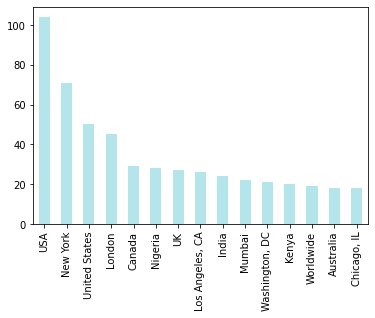

In [4]:
train['location'].value_counts().head(15).plot.bar(color="#B3E5EB")

<AxesSubplot:>

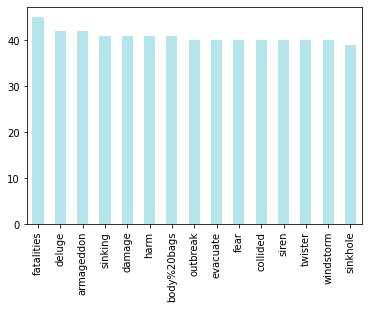

In [5]:
train['keyword'].value_counts().head(15).plot.bar(color="#B3E5EB")

<AxesSubplot:>

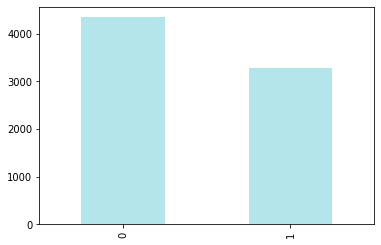

In [6]:
train['target'].value_counts().plot.bar(color="#B3E5EB")

In [7]:
train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
5       #RockyFire Update => California Hwy. 20 closed...
6       #flood #disaster Heavy rain causes flash flood...
7       I'm on top of the hill and I can see a fire in...
8       There's an emergency evacuation happening now ...
9       I'm afraid that the tornado is coming to our a...
10            Three people died from the heat wave so far
11      Haha South Tampa is getting flooded hah- WAIT ...
12      #raining #flooding #Florida #TampaBay #Tampa 1...
13                #Flood in Bago Myanmar #We arrived Bago
14      Damage to school bus on 80 in multi car crash ...
15                                         What's up man?
16                                          I love fruits
17            

1. Limpie   y   preprocese   los   datos.  

In [8]:
train.columns
# ID       : id de cada tweet
# Text     : texto del tweet
# Location : ubicación desde la que se envió el tweet
# Keyword  : palabra clave del tweet
# Target   : esto denota si un tweet es sobre un desastre real (1) o no (0). Solo aplica en trains.scv

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [9]:
# Limpieza de location
def cleanLocation(value):
  try:

    if (
      'nan' in value or
      'world' in value or
      'global' in value or
      'everywhere' in value or
      'earth' in value or
      'ss' in value or
      '?' in value or
      re.search(r"[0-9]+", value, re.I)
    ):
      return 'unknow'

    if (
      'italy' in value
    ):
      return 'italy'

    if (
      'india' in value or
      'mumbai' in value
    ):
      return 'india'
    
    if (
      'switzerland' in value or
      'geneva' in value
    ):
      return 'switzerland'
    
    if (
      'china' in value or
      'hong kong' in value
    ):
      return 'china'

    if (
      'nigeria' in value or
      'lagos' in value
    ):
      return 'nigeria'

    if (
      'japan' in value or
      'tokyo' in value
    ):
      return 'japan'

    if (
      'ontario' in value or
      'canada' in value or
      'toronto' in value or
      'calgary' in value or
      'alberta' in value or
      re.search(r"ab$", value, re.I) or
      re.search(r"bc$", value, re.I)
    ):
      return 'canada'

    if (
      'uk' == value or
      'united kingdom' in value or
      'kingdom' in value or
      'british' in value or
      'scotland' in value or
      'newcastle' in value or
      'england' in value or
      'london' in value or
      re.search(r"uk$", value, re.I)
    ):
      return 'uk'

    if (
      'nyc' == value or
      'nj' == value or
      'united states' in value or
      'new york' in value or
      'san francisco' in value or
      'los angeles' in value or
      'new jersey' in value or
      'north carolina' in value or
      'st. louis' in value or
      'kansas city' in value or
      'san diego' in value or
      'las vegas' in value or
      'sacramento' in value or
      'oregon' in value or
      'michigan' in value or
      'manchester' in value or
      'portland' in value or
      'texas' in value or
      'u.s.' in value or
      'philippines' in value or
      'nevada' in value or
      'us' in value or
      'arizona' in value or
      'lincoln' in value or
      'wisconsin' in value or
      'pennsylvania' in value or
      'seattle' in value or
      'usa' in value or
      'washington' in value or
      'florida' in value or
      'chicago' in value or
      'california' in value or
      'nashville' in value or
      'colorado' in value or
      'denver' in value or
      'cleveland' in value or
      'atlanta' in value or
      'massachusetts' in value or
      'boston' in value or
      'oklahoma' in value or
      'tennessee' in value or
      'liverpool' in value or
      'phoenix' in value or
      'baltimore' in value or
      re.search(r"nyc$", value, re.I) or
      re.search(r"hi$", value, re.I) or
      re.search(r"va$", value, re.I) or
      re.search(r"ks$", value, re.I) or
      re.search(r"la$", value, re.I) or
      re.search(r"ak$", value, re.I) or
      re.search(r"md$", value, re.I) or
      re.search(r"mo$", value, re.I) or
      re.search(r"wi$", value, re.I) or
      re.search(r"az$", value, re.I) or
      re.search(r"ga$", value, re.I) or
      re.search(r"ok$", value, re.I) or
      re.search(r"nj$", value, re.I) or
      re.search(r"wa$", value, re.I) or
      re.search(r"pa$", value, re.I) or
      re.search(r"ma$", value, re.I) or
      re.search(r"co$", value, re.I) or
      re.search(r"oh$", value, re.I) or
      re.search(r"il$", value, re.I) or
      re.search(r"tn$", value, re.I) or
      re.search(r"dc$", value, re.I) or
      re.search(r"ca$", value, re.I) or
      re.search(r"tx$", value, re.I) or
      re.search(r"nc$", value, re.I) or
      re.search(r"fl$", value, re.I) or
      re.search(r"ny$", value, re.I)
    ):
      return 'usa'

    return value
  except:
    return 'unknow'

train['location'] = train['location'].apply(lambda row: str(row).lower())
train['location'] = train['location'].apply(lambda row: cleanLocation(row))

In [10]:
# Limpieza keyword
def cleanKeyword(value):
  try:
    return singularize(value)
  except:
    return value

def analizeLema(value):
  try:
    return lemma(value)
  except:
    return value

def removeSpace(value):
  return str(value).replace('%20', ' ')

train['keyword'] = train['keyword'].apply(lambda row: cleanKeyword(row))
train['keyword'] = train['keyword'].apply(lambda row: analizeLema(row))
train['keyword'] = train['keyword'].apply(lambda row: removeSpace(row))
train['keyword'].value_counts()

flood                  109
body bag               107
scream                 105
drown                  104
bomb                   101
fatality                82
sink                    80
weapon                  78
evacuate                76
wreck                   76
collide                 74
death                   74
derail                  73
blaze                   72
quarantine              71
attack                  71
injury                  71
explode                 71
panic                   70
destroy                 69
deluge                  69
siren                   69
collapse                69
riot                    69
casualty                69
hostage                 68
crush                   68
suicide bomb            68
burn                    67
crash                   67
electrocute             66
survive                 65
hijack                  65
demolish                62
obliterate              62
nan                     61
rescue                  57
f

In [11]:
# Clean text
def removeHastags(value):
  if ('#' not in value): return value
  hashtags = re.findall(r"#[^\s]*", value, re.I)
  for hashtag in hashtags:
    value = value.replace(hashtag, '')
  return value

def removeLinks(value):
  if ('http' not in value): return value
  links = re.findall(r"http[^\s]*", value, re.I)
  for link in links:
    value = value.replace(link, '')
  return value

def removeStopWords(value):
  return ' '.join([word for word in value.split() if word not in stopWords])

def removeEmojis(value):
  items = value.split(' ')
  emojis = ''.join(item for item in items if item in emoji.EMOJI_DATA)

  if (len(emojis) > 0): print(value)

  return value

translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

cleanText = []
for index, row in train.iterrows():
  text = row['text'][:]

  # Limpiando el texto
  text = text.lower()                         # Convierte todo a minusculas
  text = text.replace('utc', '')              # Quita utc
  text = text.replace('#', '')                # Quita #
  text = text.replace('@', '')                # Quita @
  text = removeLinks(text)                    # Quita links
  text = removeEmojis(text)                  # Quita todos los emojis
  text = text.translate(translator)           # Quita todos los signos de puntuacion
  text = removeStopWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas
  
  numbers = re.findall(r"[0-9]", text, re.I)
  if (len(numbers) > 0):
    for number in numbers:
      if (number == '911'): continue

      # Quitando numeros
      text = text.replace(number, '')

  text = removeStopWords(text)                # Quita todas las stop words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas

  cleanText.append(text)

train['text'] = cleanText[:]

2. Obtenga la frecuencia de las palabras tanto de los tweets de desastres como de los
que   no.

fire 180
news 144
amp 135
disaster 121
via 121
california 115
suicide 112
police 109
people 105
killed 95
like 94
hiroshima 93
storm 89
pm 86
crash 85
fires 85
families 81
train 79
emergency 77
bomb 75
buildings 75
two 74
mh 73
nuclear 72
attack 71
video 70
wildfire 69
accident 68
bombing 68
old 67
get 66
one 65
dead 64
northern 64
burning 64
legionnaires 61
car 60
bomber 60
u 59
war 58
year 58
homes 58
new 57
still 57
obama 57
typhoon 57
atomic 56
japan 56
fatal 55
years 54
today 54
collapse 52
may 51
us 51
forest 51
man 50
first 50
debris 50
watch 50
mass 50
rt 49
malaysia 49
near 48
latest 48
water 48
home 47
severe 47
earthquake 45
injured 45
city 45
confirmed 45
found 44
oil 44
world 43
warning 43
time 43
spill 43
army 42
floods 42
th 41
derailment 41
evacuation 40
weather 40
thunderstorm 40
wreckage 40
outbreak 40
flood 39
saudi 39
migrants 39
could 38
û 38
flooding 37
say 37
missing 37
investigators 37
area 36
death 36
would 36
bridge 36
back 35
suspect 35
state 35
mosque 35
re

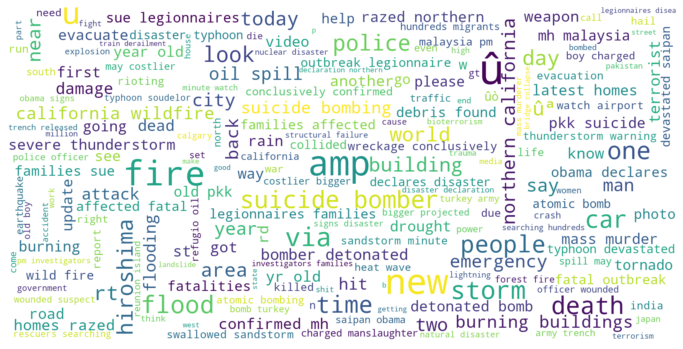

In [13]:
#Palabras que servirán para hacer un mejor modelo de clasificacion de desastres
disaster_tweets = train[train['target'] == 1]
disaster_string = []
frequency = {}

for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')

a = disaster_string.split()

for word in a:
    count = frequency.get(word, 0)
    frequency[word] = count +1 

frequency_list = frequency.keys()
sortedFrec = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))
 
for words in sortedFrec:
    print(words, frequency[words])

positiveSorted = sortedFrec

wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


like 348
amp 344
fire 252
get 229
new 225
via 220
news 201
people 200
one 197
video 166
emergency 158
disaster 157
police 142
would 137
u 136
body 130
time 130
still 129
us 128
california 121
storm 121
burning 121
crash 120
back 120
day 120
suicide 119
man 115
got 114
know 113
rt 111
buildings 110
first 108
world 106
see 105
going 104
bomb 104
two 103
pm 103
nuclear 103
fires 101
attack 101
love 101
today 99
killed 99
youtube 98
dead 98
year 98
w 96
go 96
car 94
gt 94
hiroshima 94
train 93
full 93
life 92
old 92
war 91
may 89
accident 89
families 88
good 87
think 86
watch 85
say 85
many 84
home 83
could 83
last 83
let 83
way 81
years 80
want 80
make 78
collapse 76
death 75
best 75
work 74
mh 74
mass 74
please 73
even 73
help 73
look 73
army 72
need 72
take 72
another 72
wildfire 72
really 71
û 71
bombing 71
lol 71
black 68
right 68
school 67
fatal 67
forest 66
hot 66
obama 65
water 65
northern 64
much 64
reddit 64
live 63
city 63
never 63
great 62
god 61
homes 61
legionnaires 61
bombe

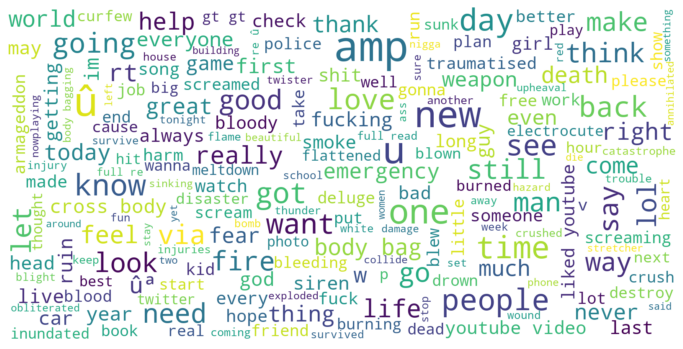

In [14]:
#Palabras que servirán para hacer un mejor modelo de clasificacion positivas
formal_tweets = train[train["target"] == 0]
noDisaster_String = []
for t in formal_tweets.text:
    noDisaster_String.append(t)
noDisaster_String = pd.Series(noDisaster_String).str.cat(sep=' ')

a = noDisaster_String.split()

for word in a:
    count = frequency.get(word, 0)
    frequency[word] = count +1 

frequency_list = frequency.keys()
sortedFrec = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))
 
for words in sortedFrec:
    print(words, frequency[words])

negativeSorted = sortedFrec

wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(noDisaster_String)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

3. Haga un análisis exploratorio de los datos

3. 1. ¿Qué palabra se repite más en cada una de las categorías?

3. 2. Haga nube de palabras para visualizar las que aparecen con másfrecuencia

3. 3. Hacer un histograma con las palabras que más se repiten

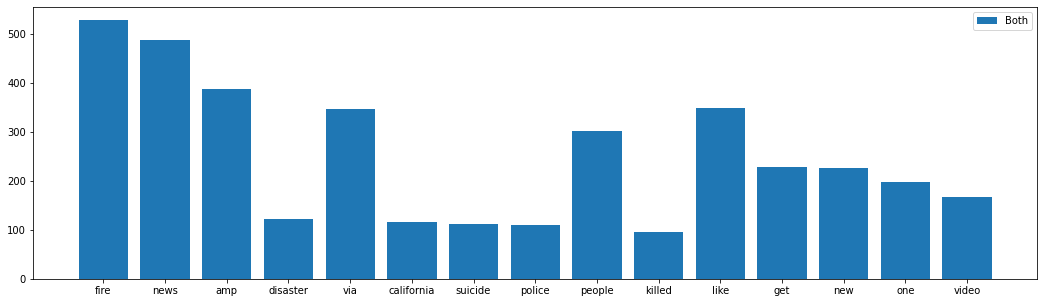

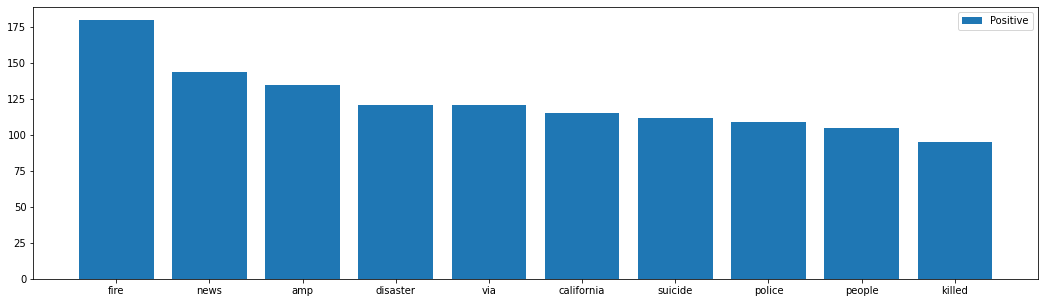

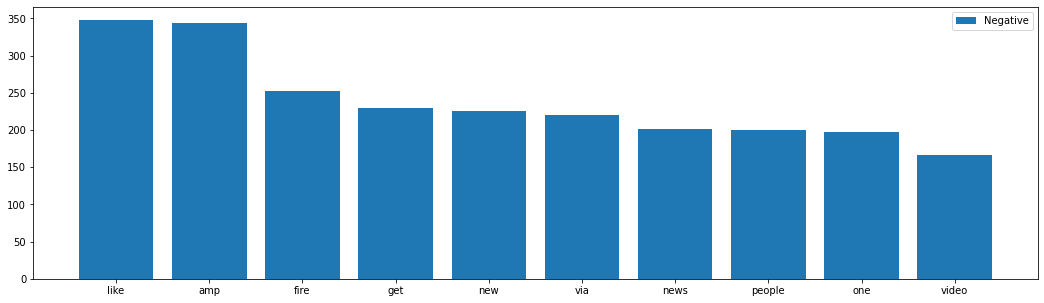

In [33]:
tenPosWords = list(positiveSorted.keys())[0:10]
tenPosFreq = list(positiveSorted.values())[0:10]

tenNegWords = list(negativeSorted.keys())[0:10]
tenNegFreq = list(negativeSorted.values())[0:10]

totPosNegWords = []
totPosNegFreq = []

# Mesh both arrays and sum their frequencies
for posi in tenPosWords:
  if tenNegWords.count(posi) > 0:
    totPosNegWords.append(posi)
    posInd = tenPosWords.index(posi)
    negInd = tenPosWords.index(posi)
    totalFreq = tenPosFreq[posInd] + tenNegFreq[negInd]
    totPosNegFreq.append(totalFreq)
  else:
    posInd = tenPosWords.index(posi)
    totPosNegWords.append(posi)
    totPosNegFreq.append(tenPosFreq[posInd])

for nega in tenNegWords:
  if tenPosWords.count(nega) == 0:
    negInd = tenNegWords.index(nega)
    totPosNegWords.append(nega)
    totPosNegFreq.append(tenNegFreq[negInd])

# Positivas y negativas
f, ax = plt.subplots(figsize=(18, 5))
plt.bar(totPosNegWords, totPosNegFreq, label="Both")
ax.legend()
plt.show()

# Positivas
f, ax = plt.subplots(figsize=(18, 5))
plt.bar(tenPosWords, tenPosFreq, label="Positive")
ax.legend()
plt.show()

# Negativas
f, ax = plt.subplots(figsize=(18, 5))
plt.bar(tenNegWords, tenNegFreq, label="Negative")
ax.legend()
plt.show()


4. Determinar que tan positivo o negativo es un tweet.

fire ->  0.001809450501476282
news ->  0.0018645391584298926
amp ->  0.0012894589121816029
disaster ->  0.0011796140167175172
via ->  0.001149056685091994
california ->  0.0011387835245609435
suicide ->  0.001006149544022878
police ->  0.0010141641483822656
people ->  0.0010105761078885195
killed ->  0.0008164701085996032


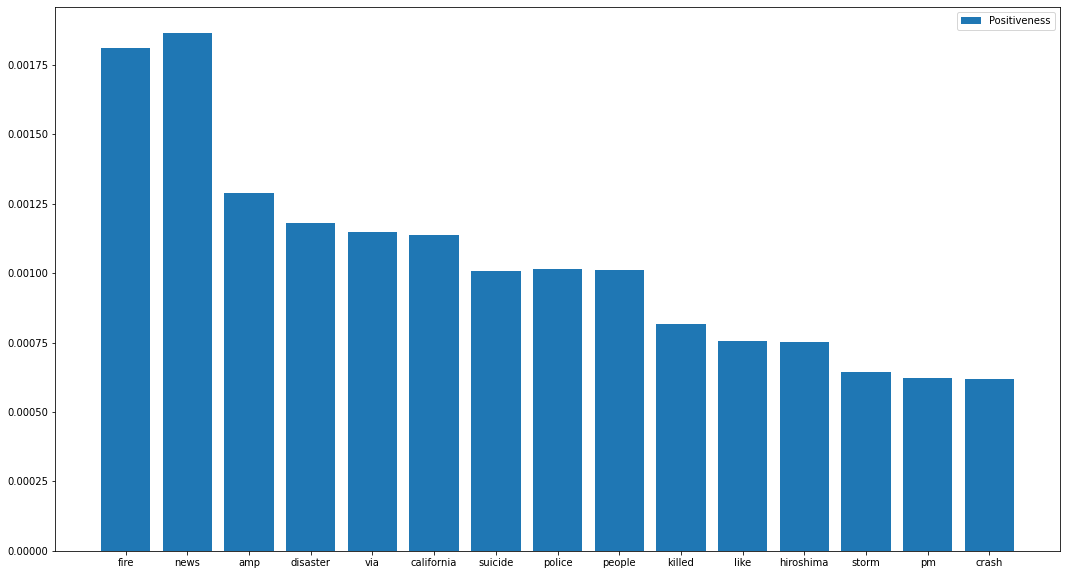

In [56]:
# Positivas
tenPosWords = list(positiveSorted.keys())
tenPosFreq = list(positiveSorted.values())

# Negativas
tenNegWords = list(negativeSorted.keys())
tenNegFreq = list(negativeSorted.values())

# Both
totPosNegWords = []
totPosNegFreq = []
totPositiveness = [] # Contains an index from -1 to 1 showing how positive or negative is a word. Being 1 Totally Positive and -1 Totally Negative

# Get total frequency per list
totalPositiveFrequency = 0
totalNegativeFrequency = 0

for freq in tenPosFreq:
  totalPositiveFrequency += freq
for freq in tenNegFreq:
  totalNegativeFrequency += freq

# Mesh both arrays and sum their frequencies
for posi in tenPosWords:
  if tenNegWords.count(posi) > 0: # Word is in both positive and negative tweets
    # Add word and get indexes
    totPosNegWords.append(posi)
    posInd = tenPosWords.index(posi)
    negInd = tenPosWords.index(posi)
    
    # Obtain frequencies
    positiveFreq = tenPosFreq[posInd]
    negativeFreq = tenNegFreq[negInd]
    totalFreq = positiveFreq + negativeFreq

    # Add frequency
    totPosNegFreq.append(totalFreq)

    positiveness = 0

    # Calculate positiveness
    if positiveFreq > negativeFreq: # More positive than negative
      # Multiply frequency over category per quantity over other category
      positiveness = (positiveFreq/totalPositiveFrequency) * ((positiveFreq - negativeFreq)/(positiveFreq + negativeFreq))
    elif negativeFreq > positiveFreq:  # More negative than positive
      positiveness = - (positiveFreq/totalPositiveFrequency) * ((positiveFreq - negativeFreq)/(positiveFreq + negativeFreq))
    elif positiveFreq == negativeFreq:  # Neutral - Only count over the total frequency of current category
      if positiveFreq/totalPositiveFrequency > negativeFreq/totalNegativeFrequency: # More frequent in positive tweets
        positiveness = positiveFreq / totalPositiveFrequency
      elif positiveFreq/totalPositiveFrequency < negativeFreq/totalNegativeFrequency: # More frequent in negative tweets
        positiveness = - negativeFreq / totalNegativeFrequency
      else: # Totally neutral
        positiveness = 0
    
    # Add positiveness
    totPositiveness.append(positiveness)

  else: # Word is only in positive tweets
    posInd = tenPosWords.index(posi)
    totPosNegWords.append(posi)
    posFreq = tenPosFreq[posInd]
    totPosNegFreq.append(posFreq)

    # Calculate and add positiveness
    positiveness = posFreq / totalPositiveFrequency
    totPositiveness.append(positiveness)

for nega in tenNegWords:
  if tenPosWords.count(nega) == 0:  # Word is only in negative tweets
    negInd = tenNegWords.index(nega)
    totPosNegWords.append(nega)

    # Get and add frequency
    negFreq = tenNegFreq[negInd]
    totPosNegFreq.append(negFreq)

    # Calculate and add positiveness
    positiveness = - negFreq / totalNegativeFrequency
    totPositiveness.append(positiveness)

# Show positiveness 
for i in  range(len(totPosNegWords[0:10])):
  print(totPosNegWords[i], "-> ", totPositiveness[i])

# Positivas y negativas
f, ax = plt.subplots(figsize=(18, 10))
plt.bar(totPosNegWords[0:15], totPositiveness[0:15], label="Positiveness")
ax.legend()
plt.show()

In [71]:
testinTrain = train.copy() # inOrder not to modifiy original

testinTrain["positiveness"] = 0

currentIndex = 0

for tweet in testinTrain["text"]:
  wordCollection = tweet.split()
  tweetPositiveness = 0
  totalOcurrences = 0

  for item in wordCollection:
    if totPosNegWords.count(item) > 0:
      wordInd = totPosNegWords.index(item)
      tweetPositiveness += totPositiveness[wordInd]
      totalOcurrences += 1
  
  # Divide by the total occurrences to maintain the value within the same range [-1, 1]
  if totalOcurrences > 0:
    tweetPositiveness /= totalOcurrences
  
  testinTrain.at[currentIndex, "positiveness"] = tweetPositiveness

  currentIndex += 1

# Show values significant to certain theta value
theta = 0.0001
testinTrain[(testinTrain["positiveness"] > theta) | (testinTrain["positiveness"] < -theta)].sample(15)
    


,id,keyword,location,text,target,positiveness
7346,10518,wildfire,usa,california battling scariest wildfire far rock...,1,0.000552
7193,10305,weapon,usa,breaking obama officials gave muslim terrorist...,1,0.000240
3674,5229,fatality,"enterprise, nv",fatality,0,0.000102
4832,6879,mass murder,usa,fredolsencruise please take faroeislands itine...,0,0.000228
2719,3905,devastate,republica dominicana,losdelsonido obama declares disaster typhoon d...,1,0.000418
2945,4235,drown,melbourne,hundreds feared drowned another mediterranean ...,1,0.000165
5860,8371,ruin,snapchat~ maddzz_babby,family ruin something actually going good,0,0.000155
3835,5458,first responder,usa,firefighters make gains rockyfire jerry brown ...,1,0.000142
5172,7377,obliterate,ondo,someone teaching obedience obliterate trials l...,1,0.000115
6817,9764,trap,shoujo hell,onihimedesu whole city trapped leave city supp...,1,0.000134


4. 1. ¿Cuáles son los 10 tweets más negativos?

In [77]:
testinTrain[testinTrain["positiveness"] < 0].sort_values(by=['positiveness'], ascending=True).head(10)

,id,keyword,location,text,target,positiveness
113,163,aftershock,belgium,aftershock,0,-0.000315
131,190,aftershock,unknow,aftershock,0,-0.000315
116,168,aftershock,unknow,ir icemoon aftershock djicemoon dubstep trapmu...,0,-0.000104
104,151,aftershock,switzerland,ir icemoon aftershock djicemoon dubstep trapmu...,0,-0.000104
106,156,aftershock,usa,ir icemoon aftershock djicemoon dubstep trapmu...,0,-0.000104
114,164,aftershock,switzerland,ir icemoon aftershock djicemoon dubstep trapmu...,0,-0.000104
115,165,aftershock,usa,ir icemoon aftershock djicemoon dubstep trapmu...,0,-0.000104
118,171,aftershock,switzerland,ir icemoon aftershock djicemoon dubstep trapmu...,0,-0.000104
119,172,aftershock,switzerland,ir icemoon aftershock djicemoon dubstep trapmu...,0,-0.000104
5975,8531,scream,usa,justinbieber arianagrande screaming,0,-0.000065


4. 2. ¿Cuáles son los 10 tweets más positivos? ¿

In [79]:
testinTrain[testinTrain["positiveness"] > 0].sort_values(by=['positiveness'], ascending=False).head(10)

,id,keyword,location,text,target,positiveness
3751,5330,fire,canada,fire,0,0.001809
2783,4003,disaster,portoviejo-manabi-ecuador,disaster,0,0.001180
3742,5319,fire,unknow,miss homasttopa cause fire fire fire yeah fire...,1,0.001019
3749,5326,fire,unknow,see fire,0,0.001011
3351,4797,evacuate,seoul,rocky fire,1,0.000964
3745,5322,fire,unknow,asshole fire,0,0.000883
6372,9106,suicide bomb,dorito land,suicide bomb,0,0.000781
1242,1790,buildings on fire,uk,tweetlikeitsseptemberth two buildings fire,1,0.000739
1251,1807,buildings on fire,uk,tweetlikeitsseptemberth two buildings fire,1,0.000739
3291,4717,evacuate,unknow,california amp monster amp fire contained told...,1,0.000738


5. Cree una variable que contenga la “negatividad” de cada tweet.